In [1]:
#%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Initializing a variable with the created engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Initializing a variable with the connection resource
connection = engine.connect()

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

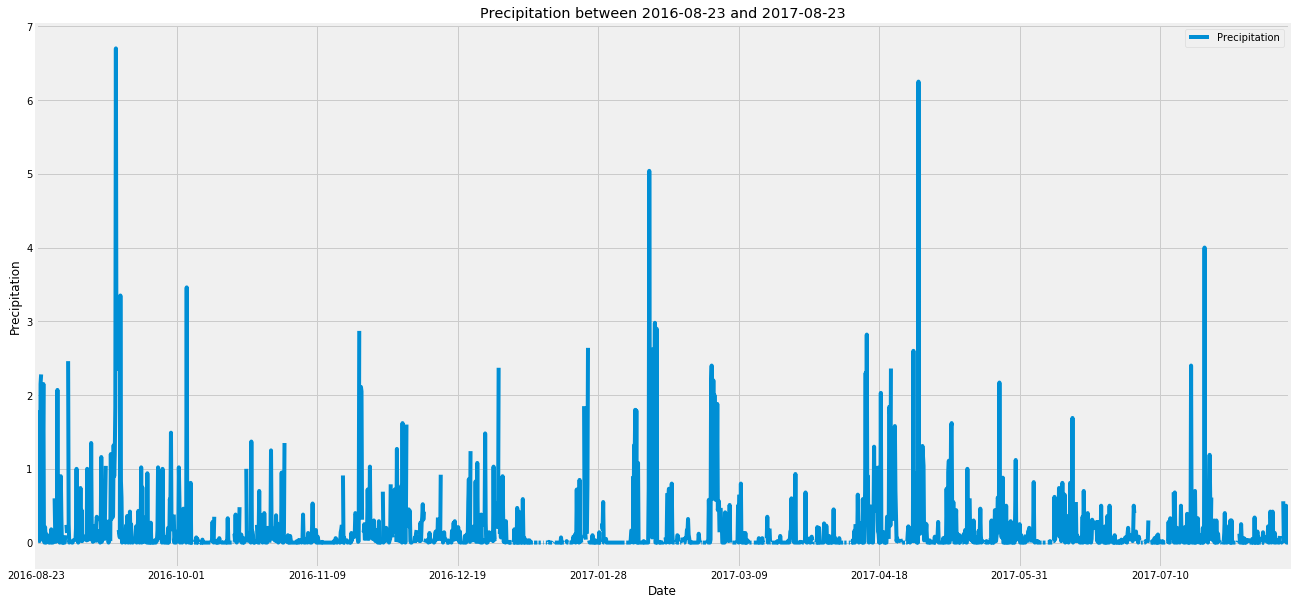

In [8]:
# Initializing a variable with the last date of precipitation values held in Measurement
last_date = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Formating the value held in last_date so that it is compatible with dt.date()
year = int(last_date[:4])
month = int(last_date[5:7])
date = int(last_date[8:10])
# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(year, month, date) - dt.timedelta(days=365)
# Design and perform a query to retrieve the last 12 months of precipitation data and plot the results
one_year_precip_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date>=year_ago_date).\
                    filter(Measurement.date<=last_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_precip_data_df = pd.DataFrame(one_year_precip_data, columns=["date", "prcp"])
# Sort the dataframe by date
one_year_precip_data_sorted_df = one_year_precip_data_df.sort_values("date", ascending=True).reset_index()
# Use Pandas Plotting with Matplotlib to plot the data
ax = one_year_precip_data_sorted_df.reset_index().plot(x="date", y="prcp", figsize=(20,10))
ax.set_title(f"Precipitation between {year_ago_date} and {last_date}")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.legend(["Precipitation"])
plt.show()

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
count = one_year_precip_data_sorted_df["prcp"].count()
mean = one_year_precip_data_sorted_df["prcp"].mean()
std = one_year_precip_data_sorted_df["prcp"].std()
min = one_year_precip_data_sorted_df["prcp"].min()
first = one_year_precip_data_sorted_df["prcp"].quantile(0.25)
second = one_year_precip_data_sorted_df["prcp"].quantile(0.5)
third = one_year_precip_data_sorted_df["prcp"].quantile(0.75)
max = one_year_precip_data_sorted_df["prcp"].max()
# Initializing a DataFrame with the summary statistics of one_year_precip_data_sorted_df
summary_statistics_df = pd.DataFrame({"count": count,
                                   "mean": mean,
                                   "std": std,
                                   "min": min,
                                   "25%": first,
                                   "50%": second,
                                   "75%": third,
                                   "max": max}, index=["precipitation"]).T
# Displaying summary_statistics_df
display(summary_statistics_df)

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).distinct().count()
print(num_stations)

9


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_activity[0][0]
most_active_lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
                      filter(Measurement.station == most_active_station).all()
most_active_highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
                      filter(Measurement.station == most_active_station).all()
most_active_avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                      filter(Measurement.station == most_active_station).all()
print(most_active_lowest_temp)
print(most_active_highest_temp)
print(most_active_avg_temp)

[('USC00519281', 54.0)]
[('USC00519281', 85.0)]
[('USC00519281', 71.66378066378067)]


In [13]:
# Choose the station with the highest number of temperature observations.
highest_temp_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()[0]
print(highest_temp_station)

USC00519281


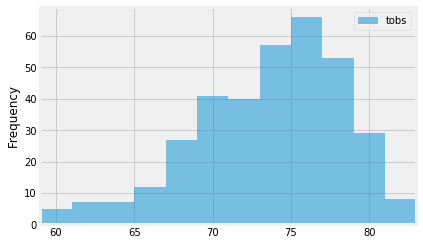

In [14]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_station_data_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == highest_temp_station).\
                            filter(Measurement.date >= year_ago_date).\
                            filter(Measurement.date <= last_date).all())
# Querying Measurements for the lowest temp so it can be used to set the xlim
lowest_temp = highest_temp_station_data_df["tobs"].min()
# Querying Measurements for the highest temp so it can be used to set the xlim
highest_temp = highest_temp_station_data_df["tobs"].max()
ax = highest_temp_station_data_df.plot.hist(bins=12, alpha=0.5)
ax.set_xlim(lowest_temp, highest_temp)
plt.show()

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_start_date = "2017-08-11"
my_trip_end_date = "2017-08-23"
my_trip_min_temp = calc_temps(my_trip_start_date, my_trip_end_date)[0][0]
my_trip_avg_temp = calc_temps(my_trip_start_date, my_trip_end_date)[0][1]
my_trip_max_temp = calc_temps(my_trip_start_date, my_trip_end_date)[0][2]
print(my_trip_min_temp)
print(my_trip_avg_temp)
print(my_trip_max_temp)

70.0
78.67307692307692
85.0


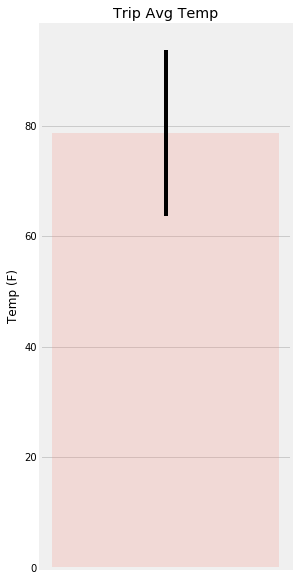

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptp = my_trip_max_temp - my_trip_min_temp
plt.figure(figsize=(4,10))
plt.bar((0,0), (my_trip_avg_temp, 0), yerr=(ptp, 0), alpha=0.2, color="salmon")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Temp (F)")
plt.show()

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude,
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_trip_window_prcp = session.query(*sel).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date>=my_trip_start_date).\
                    filter(Measurement.date<=my_trip_end_date).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()
# Displaying the query results
total_trip_window_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.9300000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.51),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.34),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.04),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)]

In [19]:
# Initializing a variable to hold a list of each station's ID
stations = session.query(Measurement.station).distinct().all()
# Initializing an empty list to hold station ID's and the last date they recorded climate data
last_station_date_list = []
# Initializing a variable a list of querie terms for this sanity check
sel = [Measurement.station, Measurement.date]
# Using a for-loop retrieve the last recording date for each station ID
for entry in stations:
    station = entry[0]
    sanity_check = session.query(*sel).filter(Measurement.station == station).\
           order_by(Measurement.date.desc()).first()
    last_station_date_list.append(sanity_check)
# Initializing a DataFrame with the resutls of the for-loop
last_station_date_df = pd.DataFrame(last_station_date_list, columns=["Station", "Last Recording Date"])
last_station_date_df = last_station_date_df.sort_values("Last Recording Date", ascending=True)
# Initializing a DataFrame with the station ID's and last recording dates of stations that stopped recording before 
# the start date of my trip
inactive_before_trip = last_station_date_df[last_station_date_df["Last Recording Date"] < my_trip_start_date]
# Displaying last_station_date_df
display(last_station_date_df)
print("Below is a list of all of the stations that stopped recoding climate data before the start date of my trip")
display(inactive_before_trip)

,Station,Last Recording Date
7,USC00511918,2015-10-30
4,USC00518838,2015-11-20
1,USC00513117,2017-07-31
3,USC00517948,2017-07-31
6,USC00519281,2017-08-18
0,USC00519397,2017-08-23
2,USC00514830,2017-08-23
5,USC00519523,2017-08-23
8,USC00516128,2017-08-23


Below is a list of all of the stations that stopped recoding climate data before the start date of my trip


,Station,Last Recording Date
7,USC00511918,2015-10-30
4,USC00518838,2015-11-20
1,USC00513117,2017-07-31
3,USC00517948,2017-07-31


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
